<a href="https://colab.research.google.com/github/ranjith28100/Coding-Deep-Learning-Algorithms/blob/main/Rain_Prediction_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the libraries

In [1]:
import torch
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
from torch import nn, optim
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Setting up everything

In [4]:
sns.set(style = 'whitegrid',palette = 'muted',font_scale = 1.2)

In [5]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]


In [6]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [7]:
rcParams['figure.figsize'] = 12, 8

In [8]:
RANDOM_SEED = 42

In [9]:
np.random.seed(RANDOM_SEED)

In [10]:
torch.manual_seed(RANDOM_SEED)

# Getting the data

In [11]:
!gdown --id 1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7

Downloading...
From: https://drive.google.com/uc?id=1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7
To: /content/weatherAUS.csv
14.2MB [00:00, 124MB/s]


In [12]:
df = pd.read_csv('weatherAUS.csv')

In [13]:
df.shape

(142193, 24)

In [14]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [15]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

In [16]:
df = df[cols]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rainfall      140787 non-null  float64
 1   Humidity3pm   138583 non-null  float64
 2   Pressure9am   128179 non-null  float64
 3   RainToday     140787 non-null  object 
 4   RainTomorrow  142193 non-null  object 
dtypes: float64(3), object(2)
memory usage: 5.4+ MB


In [18]:
df['RainToday'].replace({'No':0,'Yes':1},inplace = True)
df['RainTomorrow'].replace({'No':0,'Yes':1},inplace = True)

In [19]:
df.dropna(how = 'any',inplace =True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


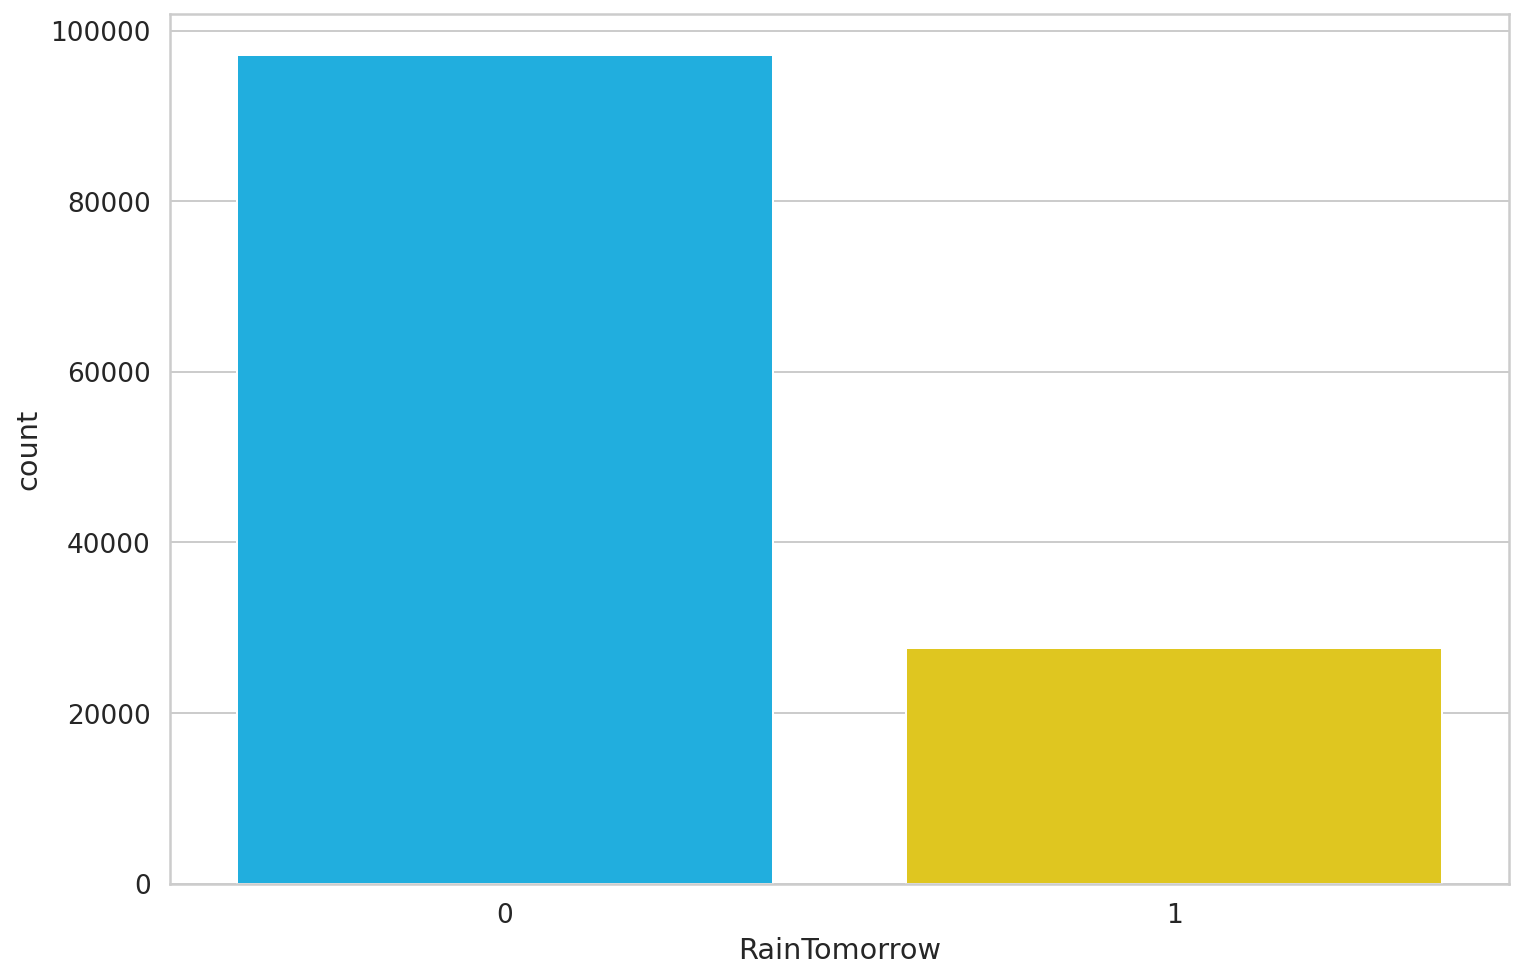

In [20]:
sns.countplot(df.RainTomorrow)

In [21]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

In [24]:
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [25]:
print(X_train.shape, y_train.shape)

torch.Size([99751, 4]) torch.Size([99751])


In [26]:
print(X_test.shape, y_test.shape)

torch.Size([24938, 4]) torch.Size([24938])


# Defining the Model

In [27]:
class Net(nn.Module):
  def __init__(self,n_features):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(n_features,5)
    self.fc2 = nn.Linear(5,3)
    self.fc3 = nn.Linear(3,1)
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [28]:
net = Net(X_train.shape[1])

In [29]:
criterion = nn.BCELoss()

In [30]:
optimizer = optim.Adam(net.parameters(),lr =0.001)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
device

device(type='cuda', index=0)

In [33]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [34]:
net = net.to(device)

In [35]:
criterion  =criterion.to(device)

In [36]:
def calculate_accuracy(y_true,y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return(y_true==predicted).sum().float()/len(y_true)

In [37]:
def round_tensor(t,decimal_places =3):
  return round(t.item(),decimal_places)

# Model Training

In [38]:
for epoch in range(1000):
  y_pred =net.forward(X_train)
  y_pred = torch.squeeze(y_pred)
  train_loss=criterion(y_pred,y_train)

  if epoch%100 ==0:
    train_acc = calculate_accuracy(y_train,y_pred)

    y_test_pred = net.forward(X_test)
    y_test_pred = torch.squeeze(y_test_pred)

    test_loss = criterion(y_test_pred, y_test)
    test_acc = calculate_accuracy(y_test, y_test_pred)

    print(f'''epoch{epoch}
          Train-loss:{round_tensor(train_loss)} Accuracy:{round_tensor(train_acc)}
           Test-loss:{round_tensor(test_loss)} Accuracy:{round_tensor(test_acc)}
          ''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


epoch0
          Train-loss:2.513 Accuracy:0.779
           Test-loss:2.517 Accuracy:0.778
          
epoch100
          Train-loss:2.265 Accuracy:0.779
           Test-loss:2.269 Accuracy:0.778
          
epoch200
          Train-loss:2.017 Accuracy:0.779
           Test-loss:2.02 Accuracy:0.778
          
epoch300
          Train-loss:1.768 Accuracy:0.779
           Test-loss:1.77 Accuracy:0.779
          
epoch400
          Train-loss:1.519 Accuracy:0.779
           Test-loss:1.521 Accuracy:0.778
          
epoch500
          Train-loss:1.27 Accuracy:0.779
           Test-loss:1.272 Accuracy:0.778
          
epoch600
          Train-loss:1.025 Accuracy:0.78
           Test-loss:1.027 Accuracy:0.779
          
epoch700
          Train-loss:0.792 Accuracy:0.78
           Test-loss:0.794 Accuracy:0.78
          
epoch800
          Train-loss:0.594 Accuracy:0.782
           Test-loss:0.596 Accuracy:0.781
          
epoch900
          Train-loss:0.484 Accuracy:0.787
           Test-loss:

# Saving the Model

In [39]:
MODEL_PATH = 'model.pth'

In [40]:
torch.save(net,MODEL_PATH)

In [41]:
classes = ['No rain', 'Raining']

#Evaluating the model

In [42]:
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

In [43]:
print(classification_report(y_test,y_pred,target_names=classes))

              precision    recall  f1-score   support

     No rain       0.81      0.96      0.88     19413
     Raining       0.62      0.22      0.33      5525

    accuracy                           0.80     24938
   macro avg       0.71      0.59      0.60     24938
weighted avg       0.77      0.80      0.76     24938



In [44]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

Text(0.5, 45.5, 'Predicted label')

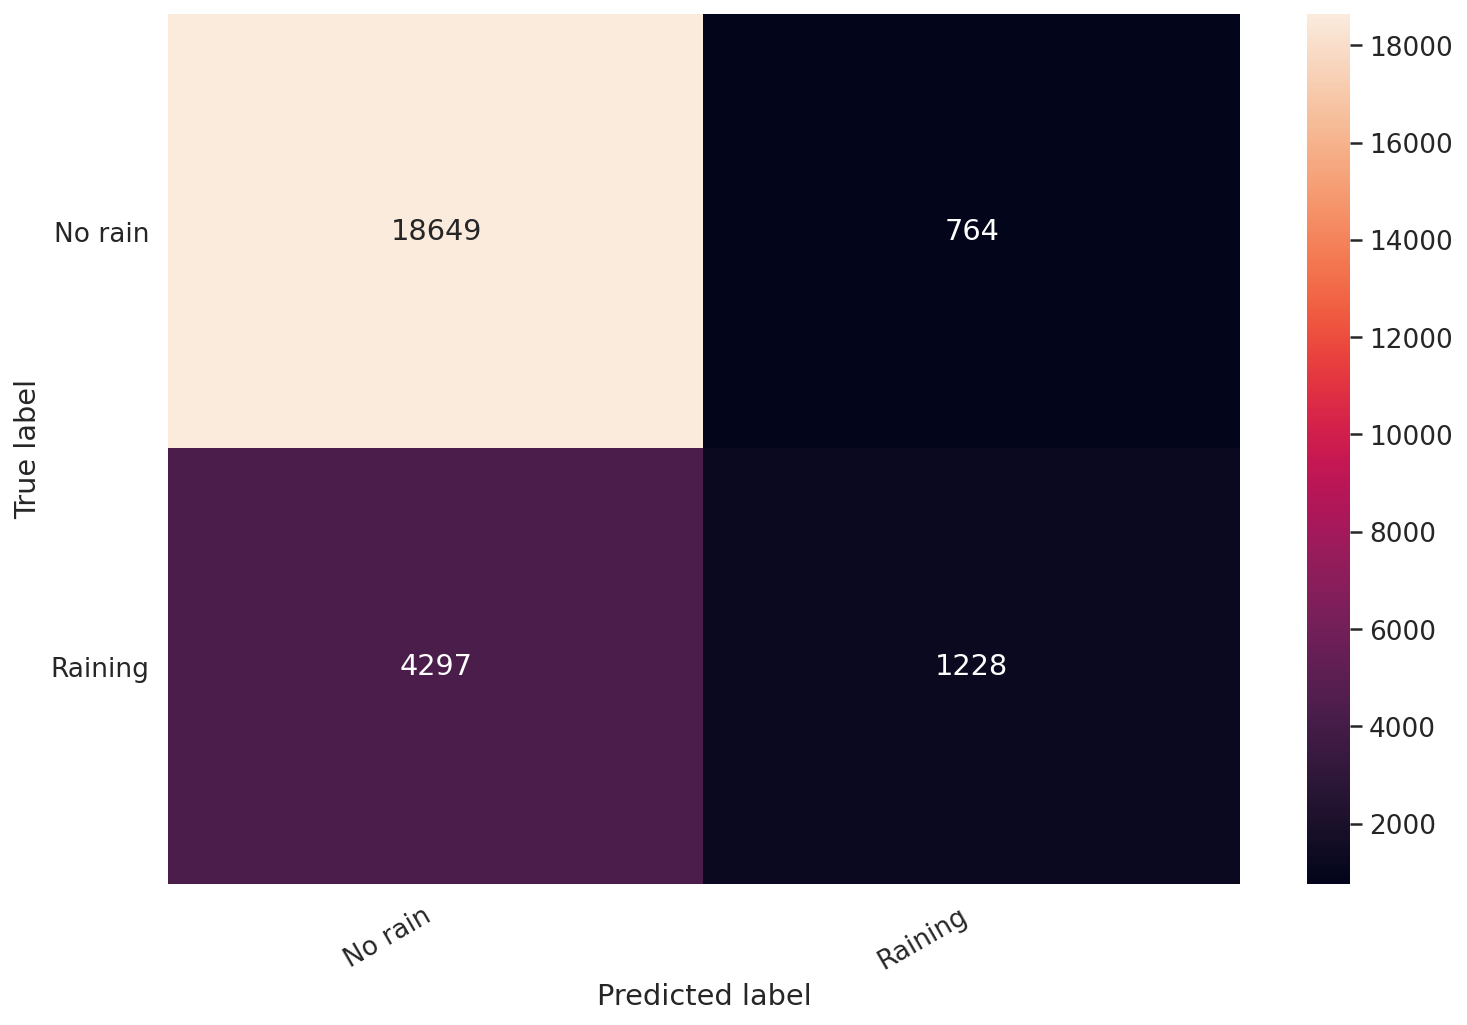

In [45]:
hmap = sns.heatmap(df_cm,annot=True,fmt ="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')